In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import func_plot as fp
import scipy.stats as ss
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression

In [2]:
mmp_fsLR = np.loadtxt('../../src/fs_LR.64k.mmp_360.txt')
ratio = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
spa = [0,1,2,99]

In [3]:
gradient = [np.loadtxt('../../results/grad/group_grad_sparsity_'+str(ratio[i])+'_fsLR_mmp.txt') for i in range(10)]
lambdas = [np.loadtxt('../../results/grad/group_grad_sparsity_'+str(ratio[i])+'_lambdas_fsLR_mmp.txt') for i in range(10)]
max_mode = 100

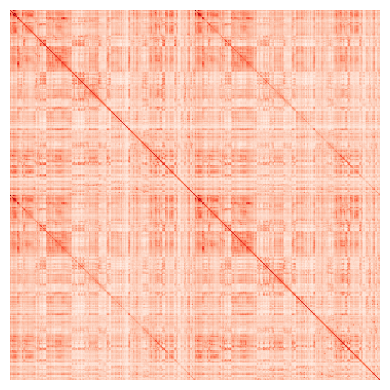

In [4]:
fc = np.loadtxt('../../results/func/fc_mean_fsLR_mmp.txt')
fig, ax = plt.subplots(figsize=(4,4))
ax.imshow(fc, cmap='Reds')
ax.set_axis_off()
fig.tight_layout()
fig.savefig('../../figures/fc_mean_fsLR_mmp.png', transparent=True, dpi=300)

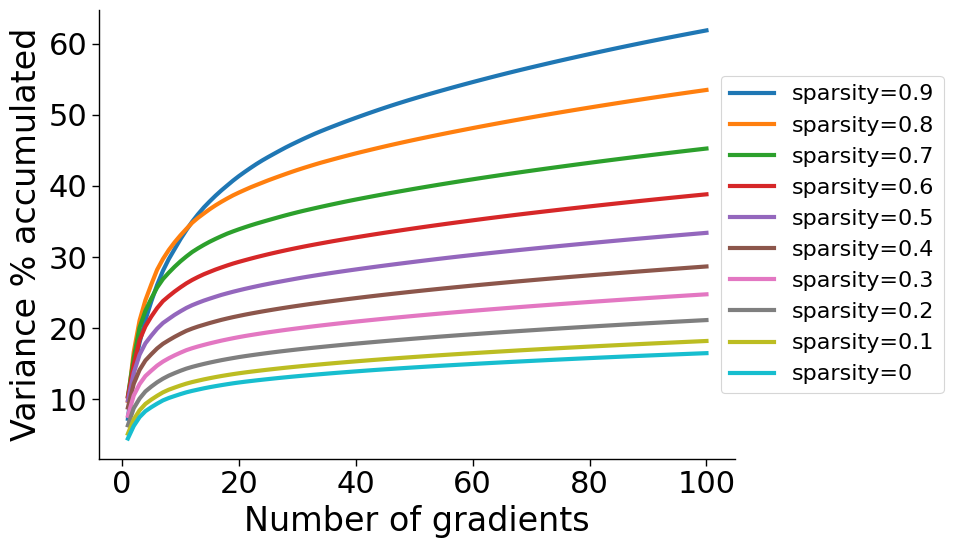

In [5]:
lambdas_acc = np.zeros((10,100))
for i in range(100):
  for j in range(10):
    lambdas_acc[j,i] = lambdas[j][:i+1].sum() * 100
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(10,6))
for i in range(10)[::-1]:
  plt.plot(range(1,101),lambdas_acc[i], lw=3, label='sparsity='+str(ratio[i]))
plt.legend(fontsize=16,loc='center left', bbox_to_anchor=(0.96, 0.5))
ax.set_xlabel('Number of gradients')
ax.set_ylabel('Variance % accumulated')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/lambdas_fsLR_mmp.png', transparent=True, dpi=300)

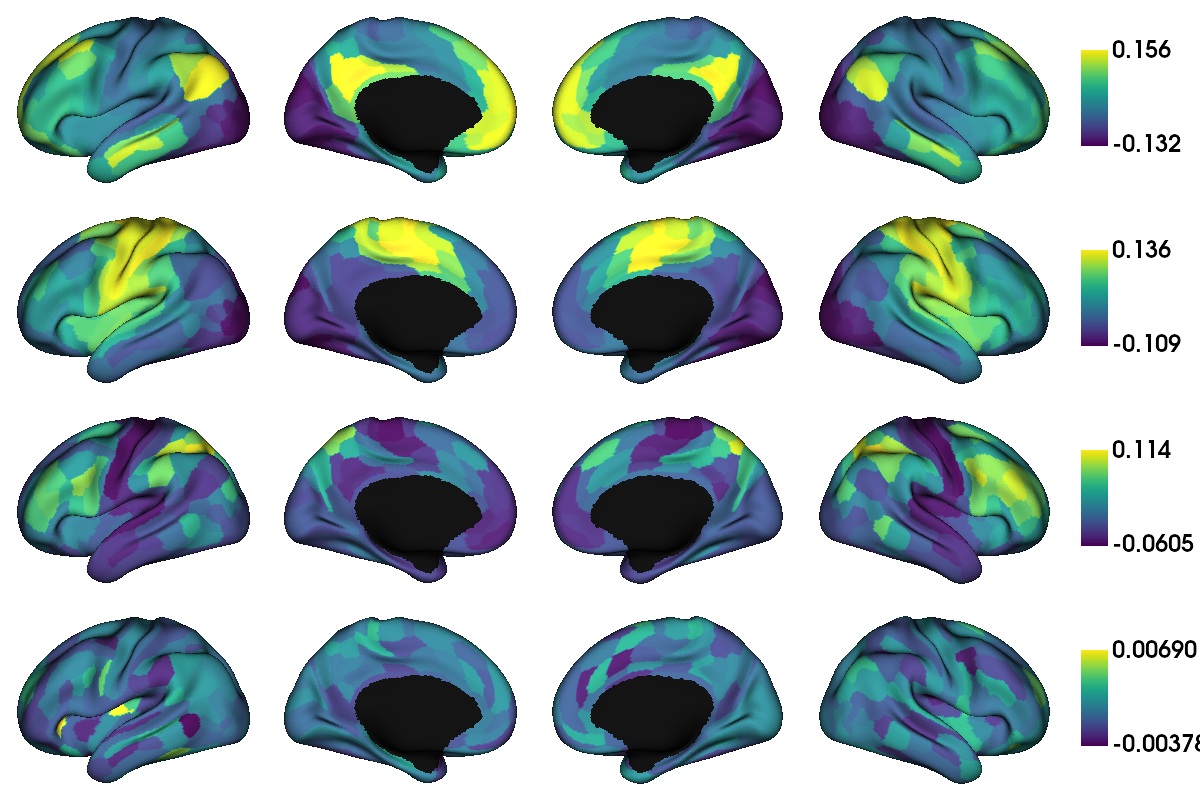

In [6]:
plot = [None] * 4
for i in range(4):
  plot[i] = mmp_fsLR.copy()
  for node in range(360):
    plot[i][mmp_fsLR==node+1] = gradient[9][:,spa[i]][node]
  plot[i][mmp_fsLR==0] = np.nan

fp.plot_surface(data = plot, surf='fsLR',
                size = (1200, 800), 
                cmap = 'viridis', filename = '../../figures/grad_fsLR_mmp_sparsity_'+str(ratio[9])+'.png',
                display=True)

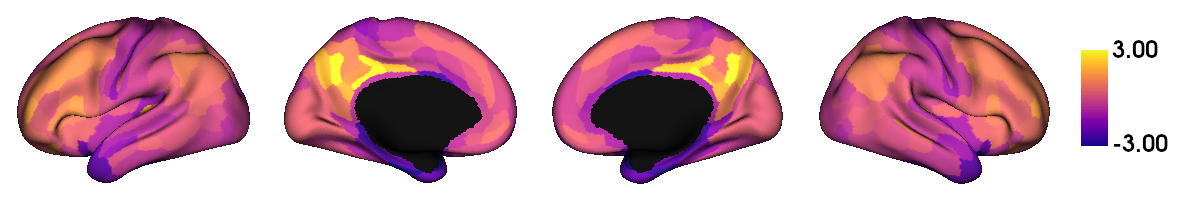

In [65]:
glucose_raw = np.loadtxt('../../results/glucose/mean_mmp.txt')
glucose_l = ss.zscore(glucose_raw[:180])
glucose_r = ss.zscore(glucose_raw[180:])
glucose = np.concatenate((glucose_l, glucose_r))
glucose_asy = glucose_l - glucose_r
plot = mmp_fsLR.copy()
for node in range(360):
  plot[mmp_fsLR==node+1] = glucose[node]
plot[mmp_fsLR==0] = np.nan
    
fp.plot_surface(data = plot, surf='fsLR',
                size = (1200, 200), color_range=(-3,3),
                cmap = 'plasma', filename = '../../figures/CMRglc_mean_fsLR_mmp.png',
                display=True)

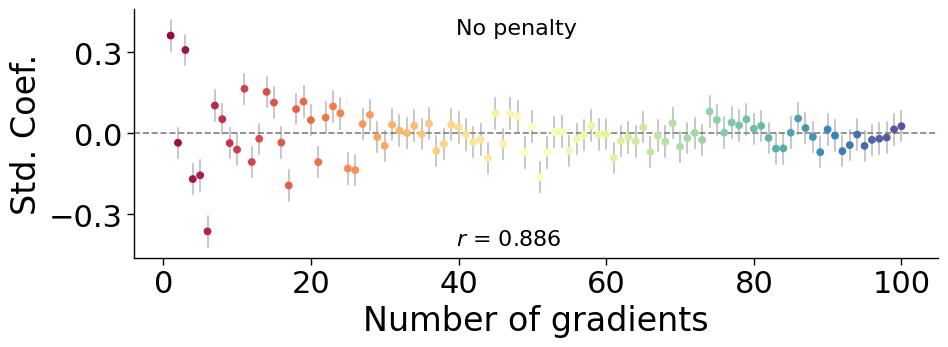

In [60]:
corr = np.zeros((10,max_mode))
for i in range(10):
  for j in range(max_mode):
    glm = OLS(glucose, gradient[i][:,:j+1]).fit()
    corr[i,j]=glm.rsquared_adj

std = gradient[i][:,:j+1].std(0)
#std[0] = 1
tt = glm.t_test(np.diag(std))

glm = OLS(glucose, gradient[9][:,:100]).fit()
y_pred = glm.predict(gradient[9][:,:100])
rp = ss.pearsonr(glucose, y_pred)

sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(10,4))
for i in range(100):
    ax.plot([i+1,i+1],[tt.summary_frame()['Conf. Int. Low'][i],tt.summary_frame()['Conf. Int. Upp.'][i]], color='gray',alpha=0.5)
ax.axhline(y=0,c='gray',ls='--')
ax.scatter(range(1,101), list(tt.summary_frame().coef),cmap='Spectral',c=range(1,101),zorder=101)
ax.set_yticks([-0.3,0,0.3])
ax.set_ylabel('Std. Coef.')
ax.set_xlabel('Number of gradients')
ax.text(0.4,0.9,'No penalty', fontsize=16, transform=ax.transAxes)
ax.text(0.4,0.05,'$\it{r}$ = '+format(rp[0], '.3f'), fontsize=16, transform=ax.transAxes)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/fitting_beta_fsLR_mmp.png', transparent=True, dpi=300)

In [61]:
tt.summary_frame().coef[np.array(abs(tt.summary_frame().coef)).argsort()[::-1]]

c5    -0.363427
c0     0.362411
c2     0.309024
c16   -0.193358
c3    -0.169632
         ...   
c34   -0.003090
c75    0.002688
c84    0.002180
c71    0.001726
c32    0.000763
Name: coef, Length: 100, dtype: float64

In [62]:
tt.summary_frame()['Conf. Int. Low'][np.array(abs(tt.summary_frame().coef)).argsort()[::-1]]

c5    -0.419948
c0     0.305891
c2     0.252503
c16   -0.249878
c3    -0.226153
         ...   
c34   -0.059610
c75   -0.053832
c84   -0.054341
c71   -0.054795
c32   -0.055757
Name: Conf. Int. Low, Length: 100, dtype: float64

In [63]:
tt.summary_frame()['Conf. Int. Upp.'][np.array(abs(tt.summary_frame().coef)).argsort()[::-1]]

c5    -0.306907
c0     0.418931
c2     0.365544
c16   -0.136837
c3    -0.113112
         ...   
c34    0.053431
c75    0.059208
c84    0.058700
c71    0.058246
c32    0.057284
Name: Conf. Int. Upp., Length: 100, dtype: float64

finalsparsity0.9_r2 = 0.7034
finalsparsity0.8_r2 = 0.7362
finalsparsity0.7_r2 = 0.7326
finalsparsity0.6_r2 = 0.7289
finalsparsity0.5_r2 = 0.7228
finalsparsity0.4_r2 = 0.7173
finalsparsity0.3_r2 = 0.7132
finalsparsity0.2_r2 = 0.7418
finalsparsity0.1_r2 = 0.7536
finalsparsity0.0_r2 = 0.7536


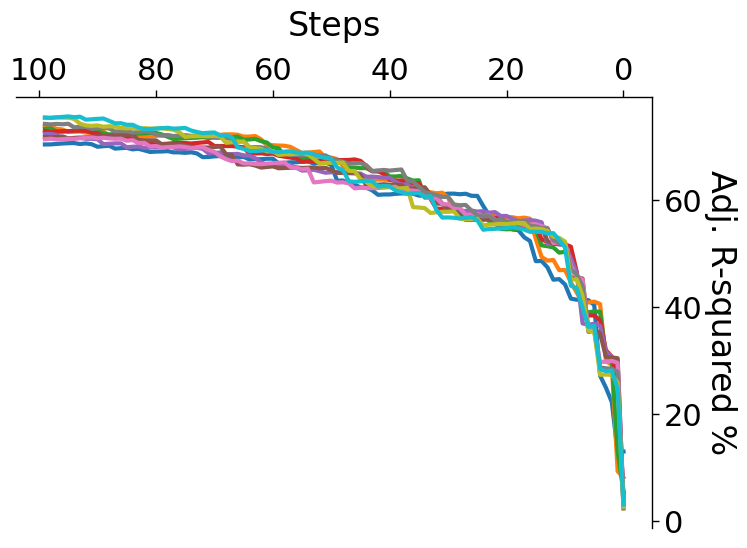

In [12]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10)[::-1]:
  ax.plot(range(1,max_mode+1), corr[i][::-1]*100, lw=3, label='sparsity=' + str(ratio[i]))
  print('finalsparsity0.'+str(i)+'_r2 =', corr[i][99].round(4))
ax.set_xlabel('Steps', labelpad=15)
ax.set_ylabel('Adj. R-squared %', rotation=270, labelpad=25)
ax.yaxis.set_label_position("right")
ax.xaxis.set_label_position("top")
ax.yaxis.tick_right()
ax.set_xticks([0,20,40,60,80,100])
ax.set_xticklabels(['100','80','60','40','20','0'])
ax.xaxis.tick_top()
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/fitting_fsLR_mmp.png', transparent=True, dpi=300)

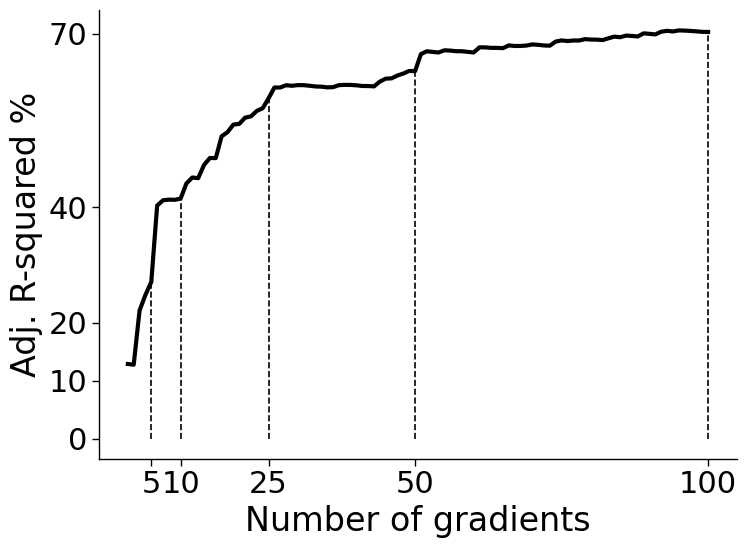

In [78]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(range(1,max_mode+1), corr[9]*100, lw=3, color='black')
ax.plot([5,5], [0,corr[9,4]*100], '--', color='black')
ax.plot([10,10], [0,corr[9,9]*100], '--', color='black')
ax.plot([25,25], [0,corr[9,24]*100], '--', color='black')
ax.plot([50,50], [0,corr[9,49]*100], '--', color='black')
ax.plot([100,100], [0,corr[9,99]*100], '--', color='black')
ax.set_xlabel('Number of gradients')
ax.set_ylabel('Adj. R-squared %')
ax.set_xticks([5,10,25,50,100])
ax.set_yticks([0,10,20,40,70])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

fig.tight_layout()
fig.savefig('../../figures/fitting_0.9_fsLR_mmp.png', transparent=True, dpi=300)

In [84]:
corr[9][4]*100,corr[9][9]*100,corr[9][24]*100,corr[9][49]*100,corr[9][99]*100,

(27.084264590709463,
 41.503925749387186,
 58.83674060775586,
 63.55087631897922,
 70.34049080245228)

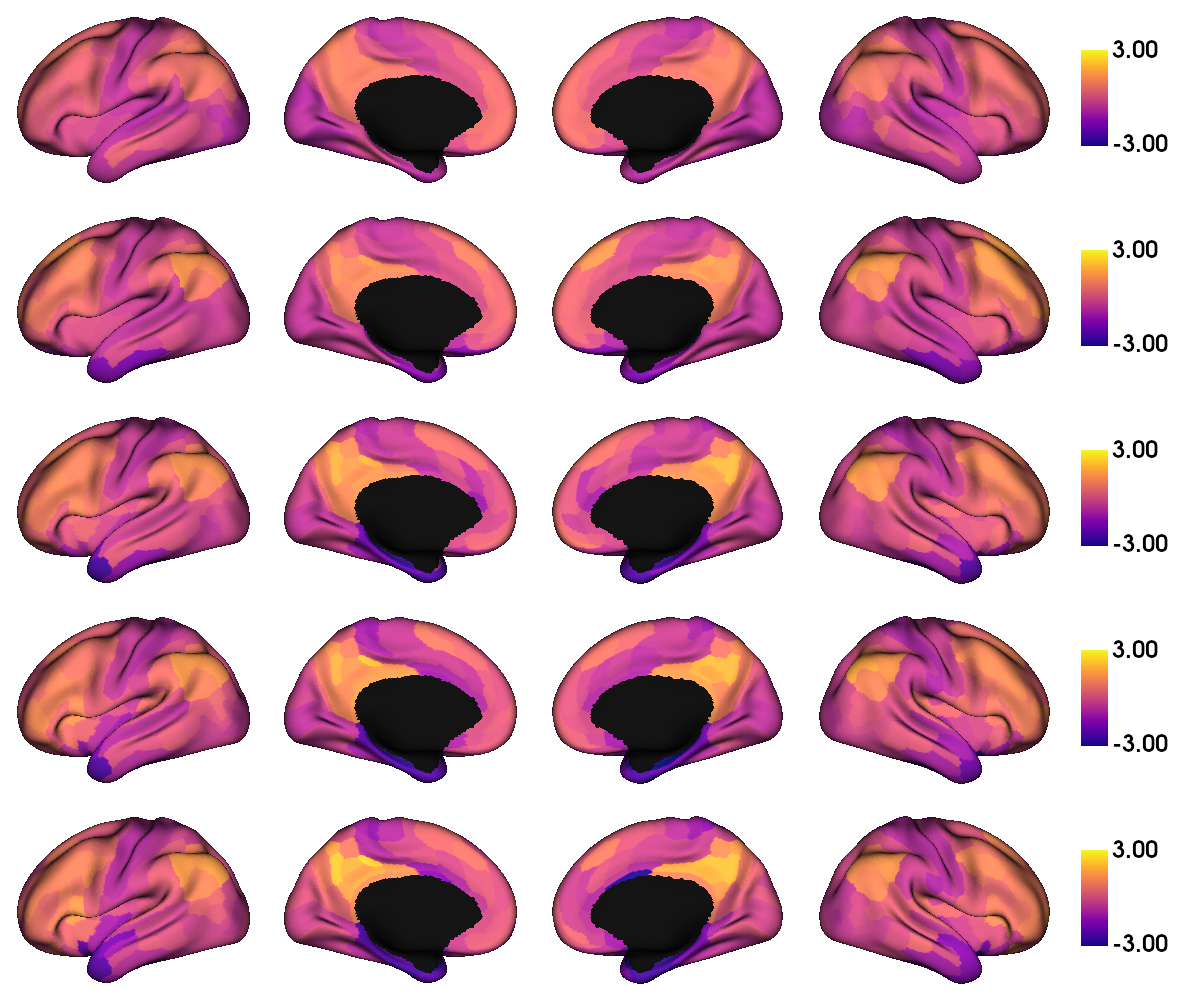

In [66]:
g=[5,10,25,50,100]
y_pred=[]
for i in range(5):
    glm = OLS(glucose, gradient[9][:,:g[i]]).fit()
    y_pred.append(glm.predict(gradient[9][:,:g[i]]))

plot = [None] * 5
for i in range(5):
  plot[i] = mmp_fsLR.copy()
  for node in range(360):
    plot[i][mmp_fsLR==node+1] = y_pred[i][node]
  plot[i][mmp_fsLR==0] = np.nan

fp.plot_surface(data = plot, surf='fsLR',
                size = (1200, 1000), color_range=(-3,3),
                cmap = 'plasma', filename = '../../figures/CMRglc_predicted.png',
                display=True)

In [80]:
corr[9][g]*100

IndexError: index 100 is out of bounds for axis 0 with size 100

In [13]:
for i in range(10):
  tmp = np.where(corr[i]>0.5)[0][0]
  print(str(tmp)+'_sparsity0.'+str(i)+'_r2 =', corr[i][tmp].round(4))
  print('10_sparsity0.'+str(i)+'_r2 =', corr[i][10].round(4))

10_sparsity0.0_r2 = 0.5108
10_sparsity0.0_r2 = 0.5108
10_sparsity0.1_r2 = 0.5218
10_sparsity0.1_r2 = 0.5218
10_sparsity0.2_r2 = 0.5196
10_sparsity0.2_r2 = 0.5196
10_sparsity0.3_r2 = 0.5197
10_sparsity0.3_r2 = 0.5197
10_sparsity0.4_r2 = 0.5177
10_sparsity0.4_r2 = 0.5177
10_sparsity0.5_r2 = 0.5154
10_sparsity0.5_r2 = 0.5154
9_sparsity0.6_r2 = 0.5122
10_sparsity0.6_r2 = 0.5166
10_sparsity0.7_r2 = 0.5025
10_sparsity0.7_r2 = 0.5025
15_sparsity0.8_r2 = 0.5262
10_sparsity0.8_r2 = 0.4685
16_sparsity0.9_r2 = 0.5228
10_sparsity0.9_r2 = 0.4415


In [14]:
for i in range(10):
  print('finalsparsity0.'+str(i)+'_r =', ss.pearsonr(lambdas_acc[i], corr[i]))

finalsparsity0.0_r = PearsonRResult(statistic=0.9894913776936777, pvalue=4.01623232244712e-84)
finalsparsity0.1_r = PearsonRResult(statistic=0.9866055722409162, pvalue=5.466530887034187e-79)
finalsparsity0.2_r = PearsonRResult(statistic=0.9828059251017407, pvalue=1.0301259218456742e-73)
finalsparsity0.3_r = PearsonRResult(statistic=0.9785805646918442, pvalue=4.4193317810850483e-69)
finalsparsity0.4_r = PearsonRResult(statistic=0.9829092298190605, pvalue=7.686214177690001e-74)
finalsparsity0.5_r = PearsonRResult(statistic=0.9794842725530448, pvalue=5.461951966125915e-70)
finalsparsity0.6_r = PearsonRResult(statistic=0.9860195514233264, pvalue=4.394772068708622e-78)
finalsparsity0.7_r = PearsonRResult(statistic=0.9893940648841513, pvalue=6.294709565975204e-84)
finalsparsity0.8_r = PearsonRResult(statistic=0.986491878430455, pvalue=8.249201783271298e-79)
finalsparsity0.9_r = PearsonRResult(statistic=0.9794093680416398, pvalue=6.518236709686776e-70)


/var/folders/lq/fcjdcml54fg745zg3nb3ftlr0000gp/T/ipykernel_5619/206035730.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, _, _, _ = np.linalg.lstsq(lambdas_acc[i].reshape(100,1),corr[i]*100)
/var/folders/lq/fcjdcml54fg745zg3nb3ftlr0000gp/T/ipykernel_5619/206035730.py:5: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope, _, _, _ = np.linalg.lstsq(lambdas_acc[i].reshape(100,1),corr[i]*100)
/var/folders/lq/fcjdcml54fg745zg3nb3ftlr0000gp/T/ipykernel_5619/206035730.py:5: FutureWarning: `rcond` parameter will ch

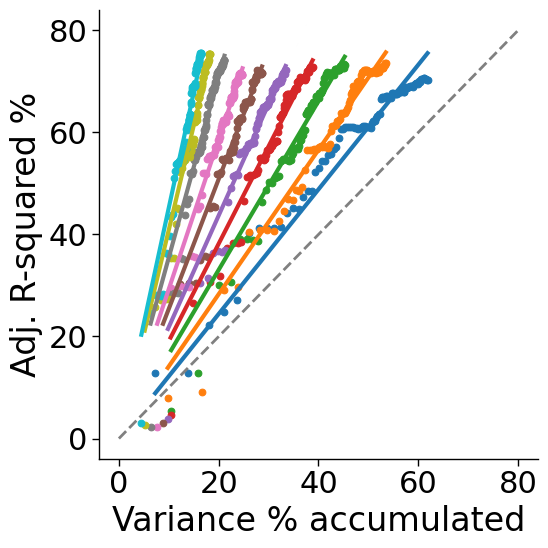

In [15]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(6,6))
for i in range(10)[::-1]:
  ax.scatter(lambdas_acc[i],corr[i]*100)
  slope, _, _, _ = np.linalg.lstsq(lambdas_acc[i].reshape(100,1),corr[i]*100)
  ax.plot(lambdas_acc[i], lambdas_acc[i] * slope, lw=3)
ax.plot([0,80], [0,80], c='gray', ls='--', lw=2)
ax.set_yticks([0,20,40,60,80])
ax.set_xticks([0,20,40,60,80])
ax.set_xlabel('Variance % accumulated')
ax.set_ylabel('Adj. R-squared %')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/variance_r2_fsLR_mmp.png', transparent=True, dpi=300)

/var/folders/lq/fcjdcml54fg745zg3nb3ftlr0000gp/T/ipykernel_5619/3381792465.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope[j], _, _, _ = np.linalg.lstsq(lambdas_acc[i][:10+j].reshape(10+j,1),corr[i][:10+j]*100)
/var/folders/lq/fcjdcml54fg745zg3nb3ftlr0000gp/T/ipykernel_5619/3381792465.py:6: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  slope[j], _, _, _ = np.linalg.lstsq(lambdas_acc[i][:10+j].reshape(10+j,1),corr[i][:10+j]*100)
/var/folders/lq/fcjdcml54fg745zg3nb3ftlr0000gp/T/ipykernel_5619/3381792465.py:6: F

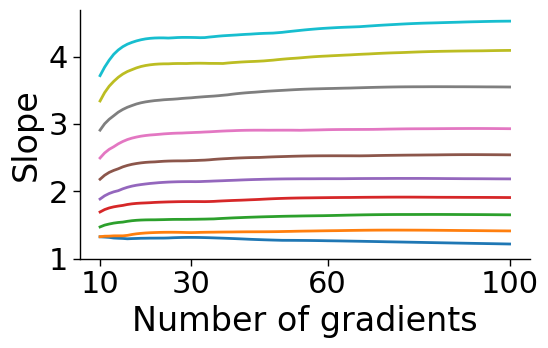

In [16]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(6,4))
for i in range(10)[::-1]:
  slope = np.zeros(91)  
  for j in range(91):
    slope[j], _, _, _ = np.linalg.lstsq(lambdas_acc[i][:10+j].reshape(10+j,1),corr[i][:10+j]*100)
  ax.plot(range(10,101,1),slope, lw=2)

ax.set_xticks([10,30,60,100])
ax.set_yticks([1,2,3,4])
ax.set_xlabel('Number of gradients')
ax.set_ylabel('Slope')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/variance_r2_slope_fsLR_mmp.png', transparent=True, dpi=300)  

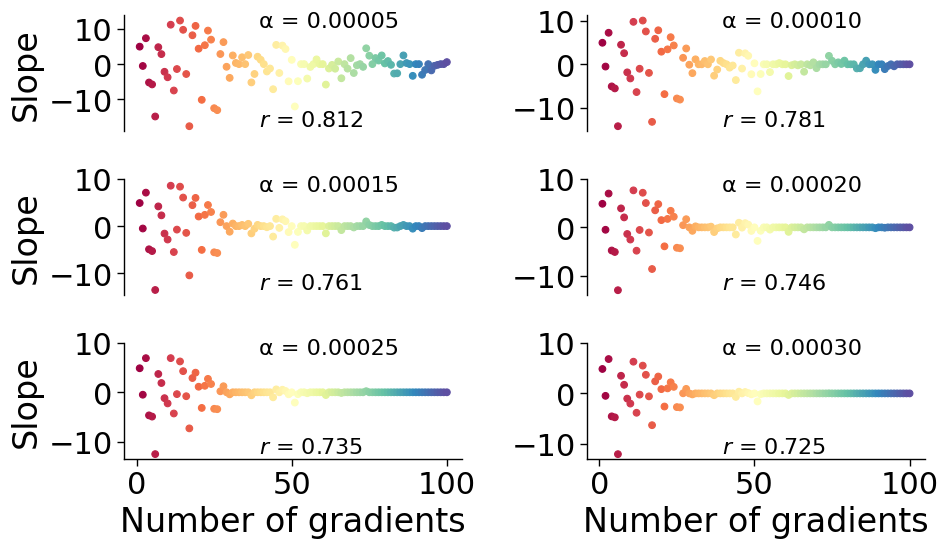

In [17]:
alphas = np.array([[0.00005,0.00010],[0.00015,0.00020],[0.00025,0.0003]])
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(3,2,figsize=(10,6))
for i in range(3):
 for j in range(2):
  glm = OLS(glucose, gradient[9][:,:101]).fit_regularized(alpha=alphas[i,j], L1_wt=0.5)
  y_pred = glm.predict(gradient[9][:,:101])
  rp = ss.pearsonr(glucose, y_pred)
  ax[i,j].scatter(range(1,101), glm.params,cmap='Spectral',c=range(1,101))
  ax[i,0].set_ylabel('Slope')
  ax[i,j].spines['right'].set_visible(False)
  ax[i,j].spines['top'].set_visible(False)
  ax[i,j].spines['bottom'].set_visible(False)
  ax[i,j].set_xticks([])
  ax[i,j].set_yticks([-10,0,10])
  ax[i,j].text(0.4,0.9,'\u03B1 = '+format(alphas[i,j], '.5f'), fontsize=16, transform=ax[i,j].transAxes)
  ax[i,j].text(0.4,0.05,'$\it{r}$ = '+format(rp[0], '.3f'), fontsize=16, transform=ax[i,j].transAxes)
ax[i,0].spines['bottom'].set_visible(True)
ax[i,0].set_xticks([0,50,100])  
ax[i,0].set_xlabel('Number of gradients')
ax[i,1].spines['bottom'].set_visible(True)
ax[i,1].set_xticks([0,50,100])  
ax[i,1].set_xlabel('Number of gradients')
fig.tight_layout()
fig.savefig('../../figures/ElasticNet_sparsity_0.9_fsLR_mmp.png', transparent=True, dpi=300)

# ASYMMETRY

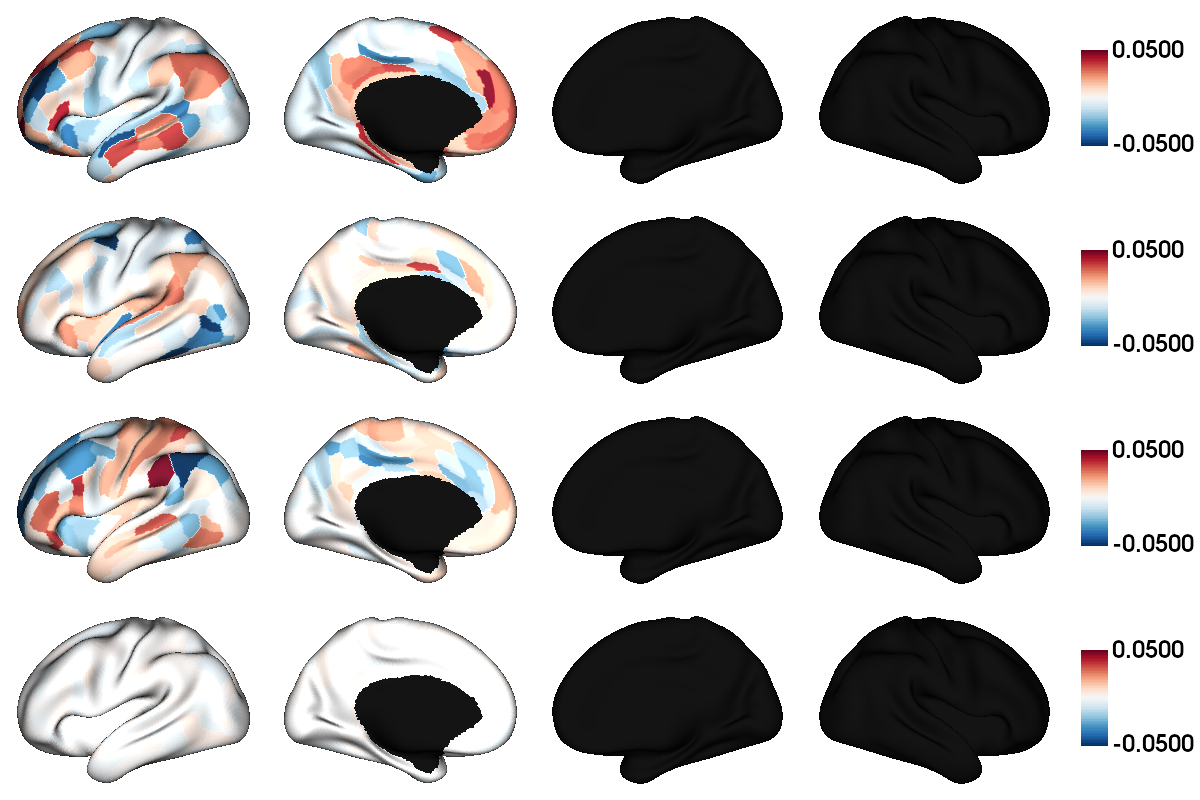

In [18]:
lhlh = [np.loadtxt('../../results/grad/group_grad_sparsity_'+str(ratio[i])+'_fsLR_mmp_lh.txt') for i in range(10)]
rhrh = [np.loadtxt('../../results/grad/group_grad_sparsity_'+str(ratio[i])+'_fsLR_mmp_rh_aligned.txt') for i in range(10)]
grad_asy = np.array(lhlh) - np.array(rhrh) 
grad_asy_plot = np.concatenate((grad_asy, np.zeros((10,180,100))),axis=1)
plot = [None] * 4
for i in range(4):
  plot[i] = mmp_fsLR.copy()
  for node in range(360):
    plot[i][mmp_fsLR==node+1] = grad_asy_plot[9][:,spa[i]][node]
  plot[i][plot[i]==0] = np.nan

fp.plot_surface(data = plot, surf='fsLR', color_range=(-0.05,0.05),
                size = (1200, 800), 
                cmap = 'RdBu_r', filename = '../../figures/asy_grad_fsLR_mmp_sparsity_'+str(ratio[9])+'.png',
                display=True)

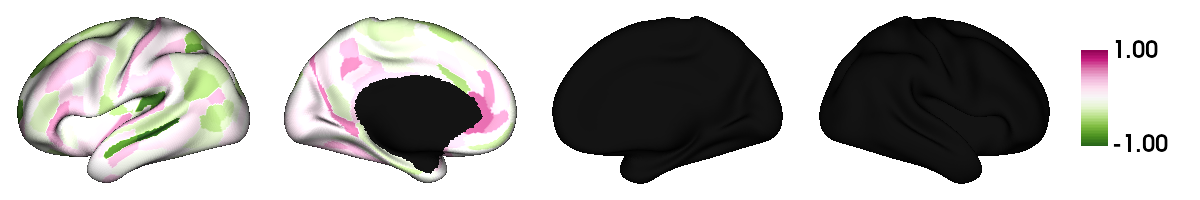

In [19]:
glucose_asy_plot = np.concatenate((glucose_asy, np.zeros(180)))
plot = mmp_fsLR.copy()
for node in range(360):
  plot[mmp_fsLR==node+1] = glucose_asy_plot[node]
plot[plot==0] = np.nan
    
fp.plot_surface(data = plot, surf='fsLR', color_range=(-1,1),
                size = (1200, 200), 
                cmap = 'PiYG_r', filename = '../../figures/asy_CMRglc_mean_fsLR_mmp.png',
                display=True)

## Left for right

In [20]:
lhlh[0].shape

(180, 100)

In [21]:
r_ll = np.zeros((10,max_mode))
r_lr = np.zeros((10,max_mode))
for i in range(10):
  for j in range(max_mode):
    glm = LinearRegression()
    glm.fit(lhlh[i][:,:j+1], glucose[:180])
    tmp = glm.predict(lhlh[i][:180,:j+1])
    r_ll[i,j]=np.corrcoef(glucose[:180], tmp)[0,1]
    tmp = glm.predict(rhrh[i][:,:j+1])
    r_lr[i,j]=np.corrcoef(glucose[180:], tmp)[0,1]

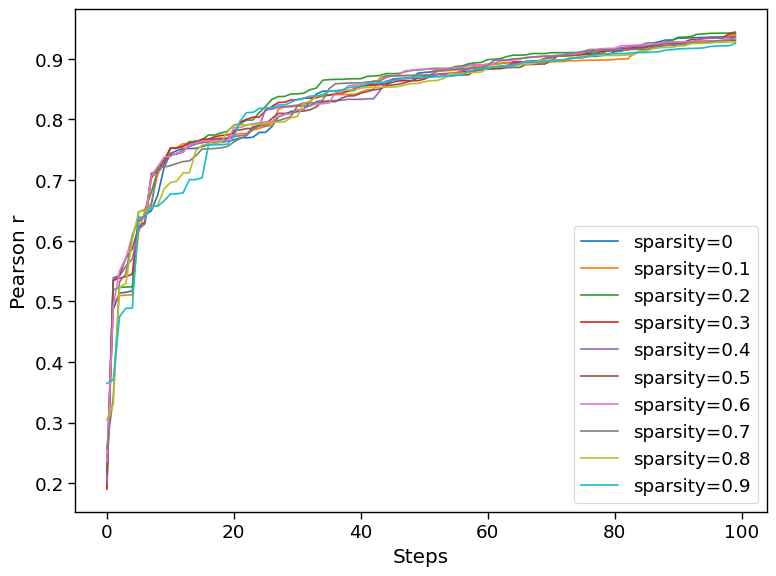

In [22]:
sns.set_context("paper", font_scale = 1.5)
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
  ax.plot(np.arange(max_mode), r_ll[i], label='sparsity=' + str(ratio[i]))
plt.legend()
ax.set_xlabel('Steps')
ax.set_ylabel('Pearson r')
fig.tight_layout()
fig.savefig('../../figures/fitting_in_LH_fsLR_mmp.png', transparent=True, dpi=300)

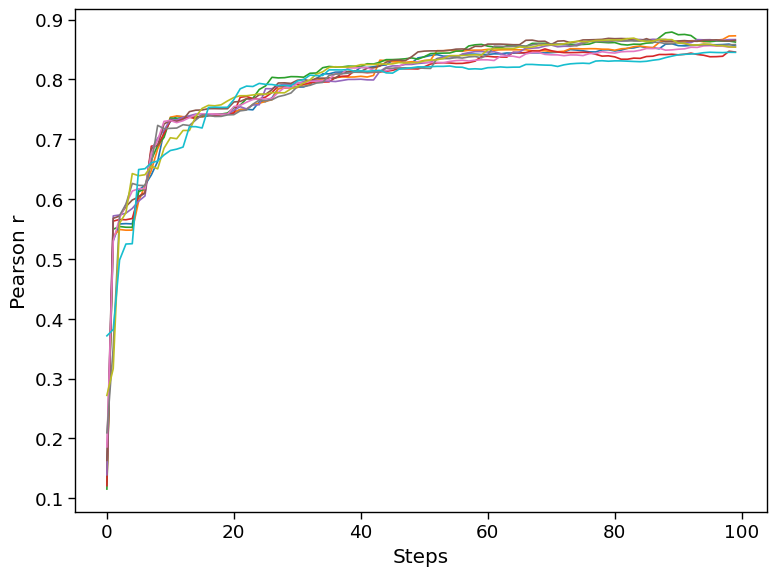

In [23]:
sns.set_context("paper", font_scale = 1.5)
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
  ax.plot(np.arange(max_mode), r_lr[i], label='sparsity=' + str(ratio[i]))
ax.set_xlabel('Steps')
ax.set_ylabel('Pearson r')
fig.tight_layout()
fig.savefig('../../figures/fitting_in_RH_refLH_fsLR_mmp.png', transparent=True, dpi=300)

## right for left

In [24]:
r_rl = np.zeros((10,max_mode))
r_rr = np.zeros((10,max_mode))
for i in range(10):
  for j in range(max_mode):
    glm = LinearRegression()
    glm.fit(rhrh[i][:,:j+1], glucose[180:])
    tmp = glm.predict(rhrh[i][:,:j+1])
    r_rr[i,j]=np.corrcoef(glucose[180:], tmp)[0,1]
    tmp = glm.predict(lhlh[i][:,:j+1])
    r_rl[i,j]=np.corrcoef(glucose[:180], tmp)[0,1]

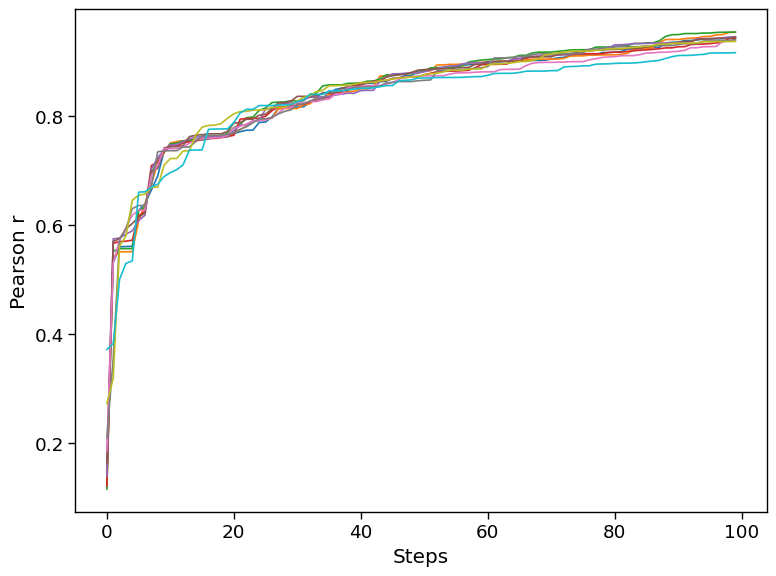

In [25]:
sns.set_context("paper", font_scale = 1.5)
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
  ax.plot(np.arange(max_mode), r_rr[i], label='sparsity=' + str(ratio[i]))
ax.set_xlabel('Steps')
ax.set_ylabel('Pearson r')
fig.tight_layout()
fig.savefig('../../figures/fitting_in_RH_fsLR_mmp.png', transparent=True, dpi=300)

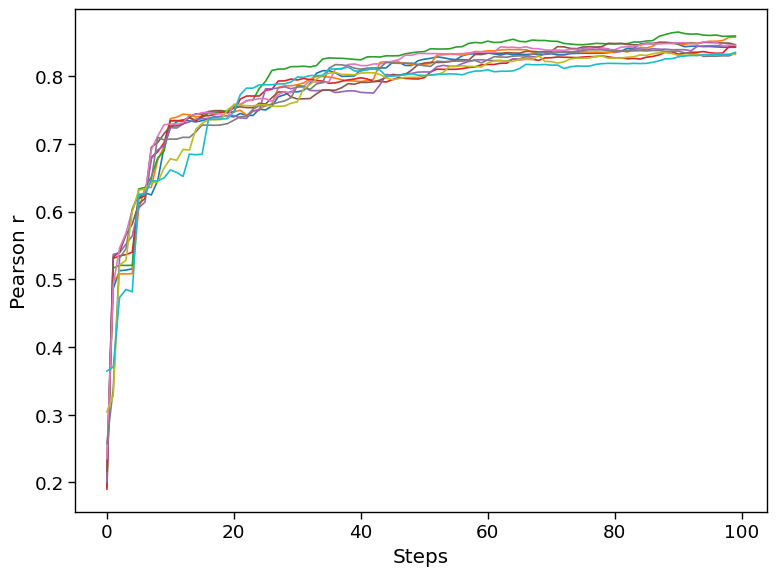

In [26]:
sns.set_context("paper", font_scale = 1.5)
fig, ax = plt.subplots(figsize=(8,6))
for i in range(10):
  ax.plot(np.arange(max_mode), r_rl[i], label='sparsity=' + str(ratio[i]))
ax.set_xlabel('Steps')
ax.set_ylabel('Pearson r')
fig.tight_layout()
fig.savefig('../../figures/fitting_in_LH_refRH_fsLR_mmp.png', transparent=True, dpi=300)

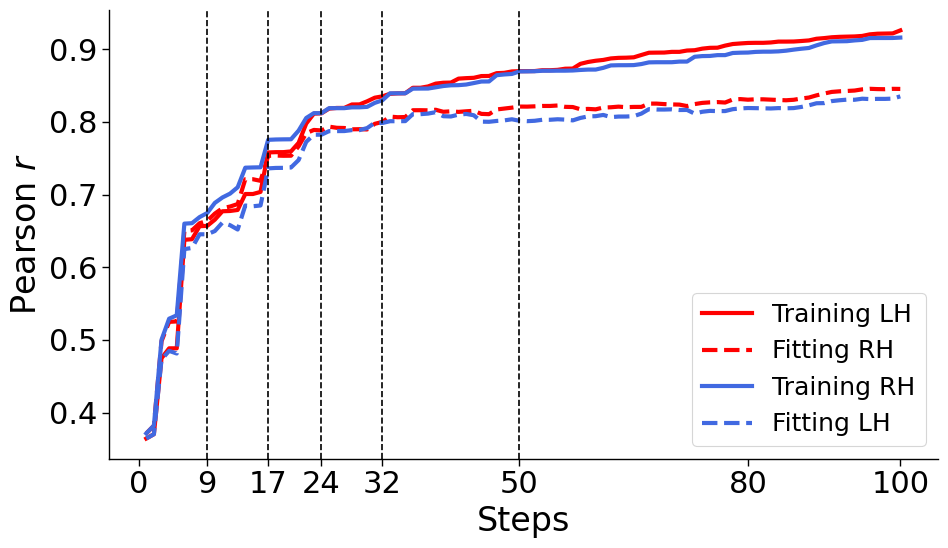

In [27]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(10,6))
i=9
ax.plot(range(1,max_mode+1), r_ll[i], label='Training LH', c='red', lw=3)
ax.plot(range(1,max_mode+1), r_lr[i], label='Fitting RH', c='red', ls='--', lw=3)
ax.plot(range(1,max_mode+1), r_rr[i], label='Training RH', c='royalblue', lw=3)
ax.plot(range(1,max_mode+1), r_rl[i], label='Fitting LH', c='royalblue', ls='--', lw=3)
ax.set_xlabel('Steps')
ax.set_ylabel('Pearson $\it{r}$')
ax.axvline(x=9,c='black',ls='--')
ax.axvline(x=17,c='black',ls='--')
ax.axvline(x=24,c='black',ls='--')
ax.axvline(x=32,c='black',ls='--')
ax.axvline(x=50,c='black',ls='--')
ax.set_xticks([0,9,17,24,32,50,80,100])
plt.legend(fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/fitting_sparsity_0.'+str(i)+'_fsLR_mmp.png', transparent=True, dpi=300)

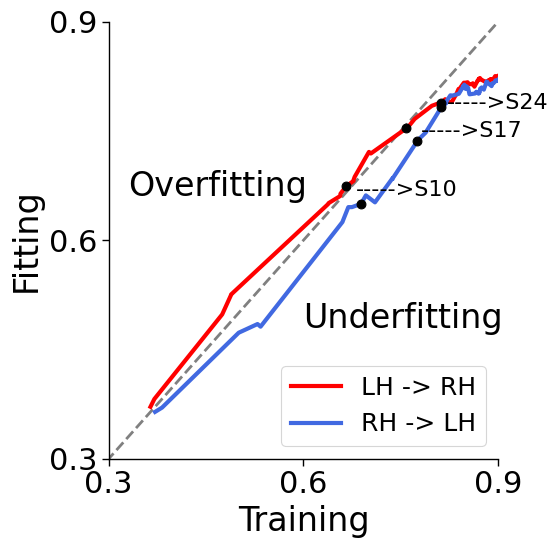

In [37]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(6,6))
i=9
ax.plot([0,1], [0,1], c='gray', ls='--', lw=2)
ax.plot(r_ll[i], r_lr[i], c='red', label='LH -> RH', lw=3)
ax.plot(r_rr[i], r_rl[i], c='royalblue', label='RH -> LH', lw=3)
ax.scatter(r_ll[i][9], r_lr[i][9], c='black',s=40,zorder=3)
ax.scatter(r_rr[i][9], r_rl[i][9], c='black',s=40,zorder=3)
ax.scatter(r_ll[i][16], r_lr[i][16], c='black',s=40,zorder=4)
ax.scatter(r_rr[i][16], r_rl[i][16], c='black',s=40,zorder=4)
ax.scatter(r_ll[i][23], r_lr[i][23], c='black',s=40,zorder=5)
ax.scatter(r_rr[i][23], r_rl[i][23], c='black',s=40,zorder=5)
ax.set_xlabel('Training')
ax.set_ylabel('Fitting')
ax.set_xlim(0.3,0.9)
ax.set_ylim(0.3,0.9)
ax.set_xticks([0.3, 0.6, 0.9])
ax.set_yticks([0.3, 0.6, 0.9])
ax.text(0.05,0.6,'Overfitting', transform=ax.transAxes)
ax.text(0.5,0.3,'Underfitting', transform=ax.transAxes)
ax.text(0.68,0.66,'----->S10',fontsize=16)
ax.text(0.78,0.742,'----->S17',fontsize=16)
ax.text(0.82,0.78,'----->S24',fontsize=16)
plt.legend(loc = 'lower right', fontsize=18)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/fitting_diag_sparsity_0.'+str(i)+'_fsLR_mmp.png', transparent=True, dpi=300)

In [29]:
r_asy = np.zeros((10,max_mode))
for i in range(10):
  for j in range(max_mode):
    glm = LinearRegression()
    glm.fit(grad_asy[i][:,:j+1], glucose_asy)
    tmp = glm.predict(grad_asy[i][:,:j+1])
    r_asy[i,j]=np.corrcoef(glucose_asy, tmp)[0,1]

In [44]:
r_asy[9][99]

0.7317718312153149

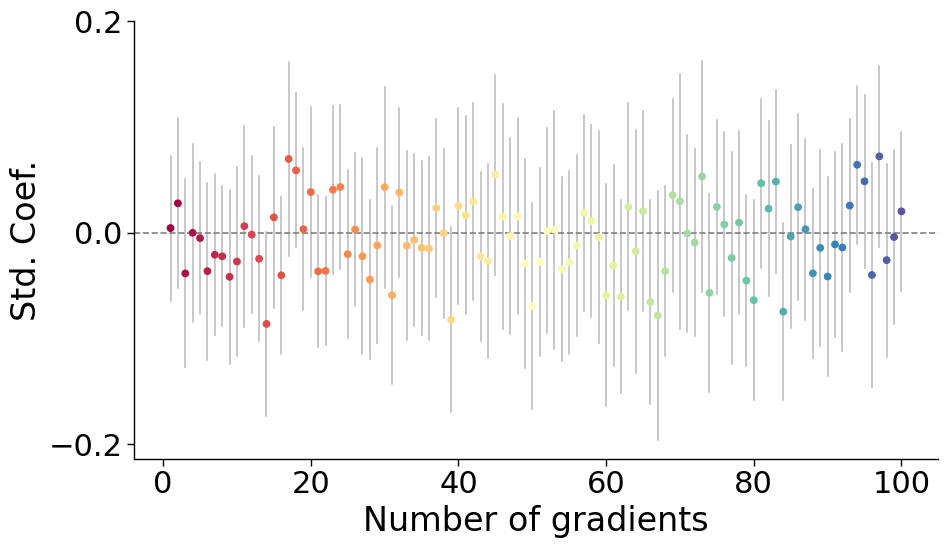

In [30]:
corr = np.zeros((10,max_mode))
for i in range(10):
  for j in range(max_mode):
    glm = OLS(glucose_asy, grad_asy[i][:,:j+1]).fit()
    corr[i,j]=glm.rsquared_adj

spa=9
std = grad_asy[spa][:,:j+1].std(0)
tt = glm.t_test(np.diag(std))

sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(10,6))
for i in range(100):
    ax.plot([i+1,i+1],[tt.summary_frame()['Conf. Int. Low'][i],tt.summary_frame()['Conf. Int. Upp.'][i]], color='gray',alpha=0.5)
ax.axhline(y=0,c='gray',ls='--')
ax.scatter(range(1,101), list(tt.summary_frame().coef),cmap='Spectral',c=range(1,101),zorder=101)
ax.set_yticks([-0.2,0,0.2])
ax.set_ylabel('Std. Coef.')
ax.set_xlabel('Number of gradients')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
fig.tight_layout()
fig.savefig('../../figures/fitting_asy_sparsity_0.'+str(spa)+'_beta_fsLR_mmp.png', transparent=True, dpi=300)

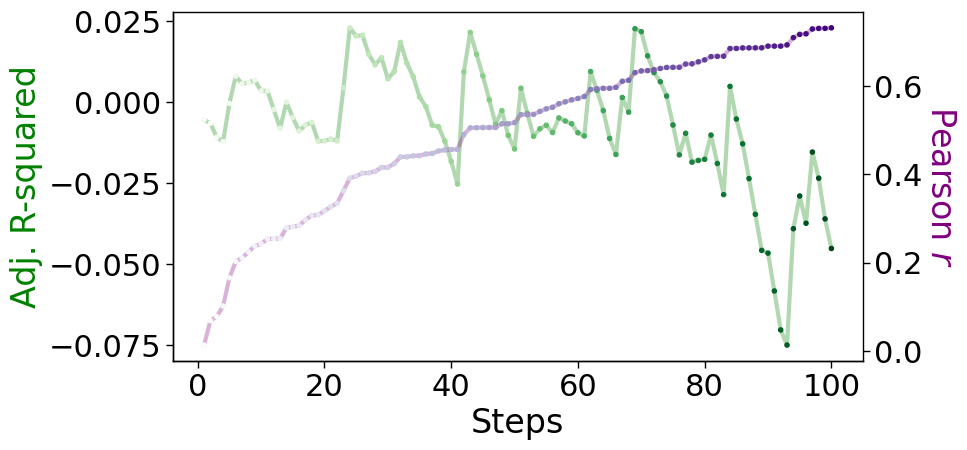

In [31]:
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(figsize=(10,5))
i=9
ax.plot(range(1,max_mode+1), corr[i], c='green', zorder=0, alpha=0.3,  lw=3)
ax.scatter(range(1,101), corr[i], cmap='Greens', c=range(1,101), s=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('Adj. R-squared', color='green')
#ax.set_yticks([-0.1,-0.05,0,0.05])

ax2=ax.twinx()
ax2.plot(range(1,101), r_asy[9], c='purple', zorder=0, alpha=0.3, lw=3)
ax2.scatter(range(1,101), r_asy[9], cmap='Purples', c=range(1,101), s=10)
ax2.set_ylabel('Pearson $\it{r}$', rotation=270, labelpad=25, color='purple')

ax.set_xlabel('Steps')
fig.tight_layout()
fig.savefig('../../figures/fitting_asy_sparsity_0.'+str(i)+'_fsLR_mmp.png', transparent=True, dpi=300)

In [32]:
corr[9].max(), np.where(corr[9]==corr[9].max())

(0.02291820894613561, (array([23]),))

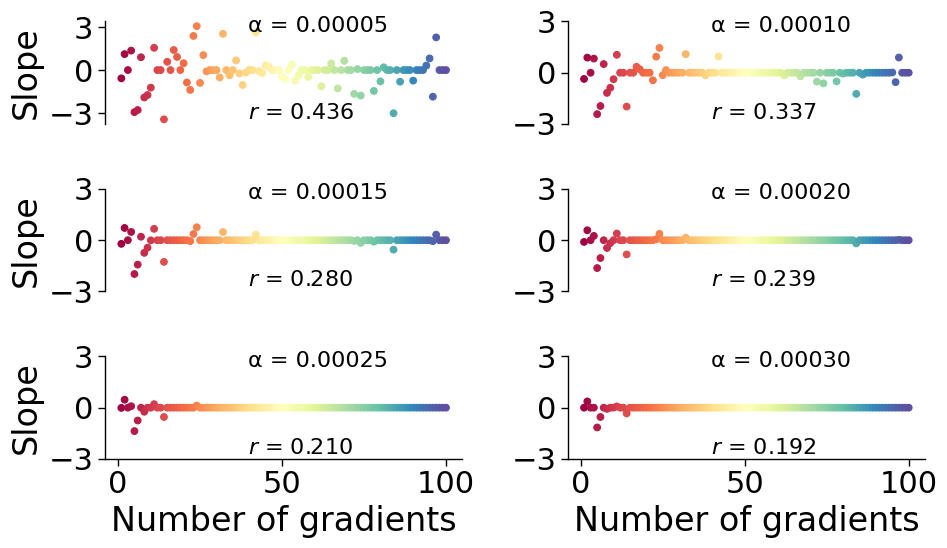

In [33]:
alphas = np.array([[0.00005,0.00010],[0.00015,0.00020],[0.00025,0.0003]])
sns.set_context("paper", font_scale = 2.5)
fig, ax = plt.subplots(3,2,figsize=(10,6))
spa=9
for i in range(3):
 for j in range(2):
  glm = OLS(glucose_asy, grad_asy[spa][:,:101]).fit_regularized(alpha=alphas[i,j], L1_wt=0.5)
  y_pred = glm.predict(grad_asy[spa][:,:101])
  rp = ss.pearsonr(glucose_asy, y_pred)
  ax[i,j].scatter(range(1,101), glm.params,cmap='Spectral',c=range(1,101))
  ax[i,0].set_ylabel('Slope')
  ax[i,j].spines['right'].set_visible(False)
  ax[i,j].spines['top'].set_visible(False)
  ax[i,j].spines['bottom'].set_visible(False)
  ax[i,j].set_xticks([])
  ax[i,j].set_yticks([-3,0,3])
  ax[i,j].text(0.4,0.9,'\u03B1 = '+format(alphas[i,j], '.5f'), fontsize=16, transform=ax[i,j].transAxes)
  ax[i,j].text(0.4,0.05,'$\it{r}$ = '+format(rp[0], '.3f'), fontsize=16, transform=ax[i,j].transAxes)
ax[i,0].spines['bottom'].set_visible(True)
ax[i,0].set_xticks([0,50,100])  
ax[i,0].set_xlabel('Number of gradients')
ax[i,1].spines['bottom'].set_visible(True)
ax[i,1].set_xticks([0,50,100])  
ax[i,1].set_xlabel('Number of gradients')
fig.tight_layout()
fig.savefig('../../figures/ElasticNet_asy_sparsity_0.'+str(spa)+'_fsLR_mmp.png', transparent=True, dpi=300)